<a href="https://colab.research.google.com/github/ZahYou/my_other_project/blob/main/Nasas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Exploring
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import
from keras.callbacks import LearningRateScheduler

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report,auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split,StratifiedShuffleSplit,cross_val_score, StratifiedKFold
from scipy.stats import randint

# Model
from sklearn.ensemble import VotingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

Data Acquisition

Download C‑MAPSS data (FD001–FD004 subsets)
arxiv.org
+11
data.nasa.gov
+11
arxiv.org
+11

Exploratory Data Analysis

Plot sensor trends over time

Visualize failure patterns

Data Pre‑processing

Calculate RUL labels: max_cycles – current_cycle

Add rolling-window aggregates for sensor signals

Normalize continuous data

Train/Validation Split

Leave a few engine units (e.g., from FD001) for final validation

Use time-aware split to avoid data leakage

Feature Engineering

Lag features (e.g., past 5 cycles)

Cycle count or operational mode encoding

Modeling

Baseline: RandomForest/GBM

Advanced: LSTM or 1D‑CNN for temporal modeling
paperswithcode.com
+1
nasa.gov
+1
kaggle.com
+12
arxiv.org
+12
data.nasa.gov
+12
data.nasa.gov
+5
github.com
+5
paperswithcode.com
+5
balabala76.medium.com
arxiv.org
+1
c3.ndc.nasa.gov
+1

Evaluation

RMSE on RUL prediction

Visualize prediction vs actual cycles

Error Analysis

Investigate high-error units

Explore sensor profiles causing mis-estimation

Model Improvement

Add more deep learning layers or use physics‑informed constraints
arxiv.org
+3
arxiv.org
+3
arxiv.org
+3
arxiv.org

Deployment

Export model (TensorFlow SavedModel or ONNX)

Prepare inference script with real-time data processing

Reporting

Technical report + dashboard visualizing predictions and confidence intervals

In [7]:
import os

os.getcwd()

'/content'

### Goal:

Predict the Remaining Useful Life (RUL) of turbofan engines using time-series sensor data from the CMAPSS dataset. The aim is to

enable predictive maintenance—anticipating failures before they occur to optimize maintenance schedules and minimize downtime

1. Introduction & Problem Statement
2. Literature Review (highlighting state-of-the-art and gaps)
3. Dataset Exploration & Preprocessing
4. Feature Engineering & Selection
5. Model Design (with justifications)
6. Training & Evaluation
7. Interpretability & Uncertainty Quantification
8. Results & Discussion
9. Conclusions & Future Work

In [8]:
"""import os
filesname = os.listdir("c:\\Users\\youne\\Desktop\\Moje Projekty\\Kaggle\\NaSas\\DATA")
for file in filesname:
    print(file)"""

'import os\nfilesname = os.listdir("c:\\Users\\youne\\Desktop\\Moje Projekty\\Kaggle\\NaSas\\DATA")\nfor file in filesname:\n    print(file)'

In [9]:
# Define Columns name for indexing
index_name = ["unit_nr", "time_in_cycles"]
settings_name = ["op_setting_1","op_setting_2", "op_setting_3"]
sensors_name = [f"sensor_{i}" for i in range(22)]

cols_name = index_name + settings_name + sensors_name
#Load train,test and target with columns name
train_df = pd.read_csv("train_FD001.txt", header = None, sep= " ")
test_df = pd.read_csv("test_FD001.txt", header = None, sep= " ")

columns = ['engine_number', 'time_in_cycles'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 24)]
train_df.columns = columns
test_df.columns = columns

test_df.columns = columns

test_df = test_df.iloc[0:].reset_index(drop=True)

test_df = test_df.drop(index=0).reset_index(drop=True)
train_df.columns = columns

train_df = train_df.iloc[0:].reset_index(drop=True)

train_df = train_df.drop(index=0).reset_index(drop=True)

In [10]:
train_df = train_df.iloc[:, :-2]
test_df = test_df.iloc[:, :-2]

In [11]:
print(train_df['engine_number'].nunique(), 'engines in the dataset')

100 engines in the dataset


In [12]:
print(test_df['engine_number'].nunique(), 'engines in the dataset')

100 engines in the dataset


In [13]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (20630, 26)
Test shape: (13095, 26)


In [14]:
def search_constant(df):
    return df.columns[df.nunique() == 1].to_list()

In [15]:
#train_df = train_df.drop(columns=search_constant(train_df))
#test_df = test_df.drop(columns=search_constant(test_df))


In [16]:
train_df.head()

,engine_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669


### How to Generate RUL Labels

#### For each engine (unit), RUL at each cycle is:  RUL = max_cycle_for_engine − current_cycle


In [17]:
# Group by eingin and get the max cycle for each
train_df['time_in_cycles'] = pd.to_numeric(train_df['time_in_cycles'], errors='coerce')

rul = pd.DataFrame(train_df.groupby('engine_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['engine_number', 'max_time_in_cycles']
train_df = train_df.merge(rul, on='engine_number')

train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop('max_time_in_cycles', axis=1, inplace=True)

train_df['RUL'] = train_df['RUL'].apply(lambda x: min(x, 130))

#time_window = 50
#train_df['label'] = train_df['RUL'].apply(lambda x: 1 if x > time_window else 0)

In [18]:
train_df.head()

,engine_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,130


### [Raw Clean Data] (no NaNs)

  ⮕ Keep all sensors, even low-variance ones

  ⮕ Normalize (StandardScaler or MinMax)

  ⮕ Generate time series sequences (sliding window)

  ⮕ Train a baseline deep model (e.g., LSTM or Conv1D)

  ⮕ Evaluate: MAE, RMSE, error curves vs. cycle

  ⮕ THEN perform sensor ablation / feature pruning


In [19]:
from sklearn.preprocessing import StandardScaler
# not use for now
"""feature_cols = [
    'op_setting_1', 'op_setting_2',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7',
    'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13',
    'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'
]"""

# Columns to normalize. low and high
feature_cols = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
    'sensor_20', 'sensor_21'
]
# Hash operating conditions
train_df["op_hash"] = train_df[["op_setting_1", "op_setting_2","op_setting_3"]].round(3).astype(str).agg("_".join, axis=1)
test_df["op_hash"] = test_df[["op_setting_1", "op_setting_2","op_setting_3"]].round(3).astype(str).agg("_".join, axis=1)


scaler = StandardScaler()

# Columns to normalize
feature_cols = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
    'sensor_20', 'sensor_21'
]

scalers = {}

# Normalize training set per op_hash group
for op_id, group in train_df.groupby("op_hash"):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(group[feature_cols])
    train_df.loc[group.index, feature_cols] = scaled_features
    scalers[op_id] = scaler  # save the scaler for that op_hash

# Normalize test set using corresponding scalers
for op_id, group in test_df.groupby("op_hash"):
    if op_id in scalers:
        scaler = scalers[op_id]
        scaled_features = scaler.transform(group[feature_cols])
        test_df.loc[group.index, feature_cols] = scaled_features
    else:
        print(f"⚠️ Warning: op_hash {op_id} in test not seen in train. Skipping normalization.")




/tmp/ipython-input-19-42438443.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.70710678 -0.70710678  1.41421356]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[group.index, feature_cols] = scaled_features
/tmp/ipython-input-19-42438443.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.70710678]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[group.index, feature_cols] = scaled_features


⚠️ Warning: op_hash -0.007_0.001_100.0 in test not seen in train. Skipping normalization.
⚠️ Warning: op_hash 0.008_0.0_100.0 in test not seen in train. Skipping normalization.


In [20]:
# Mean ~0, std ~1
print(train_df[feature_cols].mean())
print(train_df[feature_cols].std())

# Confirm no leakage
assert 'RUL' in train_df.columns
assert train_df['RUL'].max() > 0

op_setting_1   -5.717406e-17
op_setting_2   -3.719758e-17
op_setting_3    0.000000e+00
sensor_1       -2.674369e-14
sensor_2       -3.397379e-15
sensor_3       -1.377688e-16
sensor_4       -5.001008e-16
sensor_5       -2.348786e-15
sensor_6       -2.599957e-12
sensor_7       -1.086996e-14
sensor_8        1.259911e-12
sensor_9        1.133562e-14
sensor_10      -2.038871e-16
sensor_11      -2.033468e-15
sensor_12       1.235098e-14
sensor_13      -1.413087e-12
sensor_14      -1.454839e-14
sensor_15      -6.971103e-15
sensor_16      -7.616639e-18
sensor_17      -7.990592e-17
sensor_18       0.000000e+00
sensor_19       0.000000e+00
sensor_20       6.447581e-16
sensor_21      -3.517238e-15
dtype: float64
op_setting_1    9.999030e-01
op_setting_2    9.973546e-01
op_setting_3    0.000000e+00
sensor_1        6.119650e-14
sensor_2        9.999030e-01
sensor_3        9.999030e-01
sensor_4        9.999030e-01
sensor_5        1.118971e-15
sensor_6        9.877086e-01
sensor_7        9.999030e-01

#### Generate Time-Series Sequences (Sliding Window)
Now reshape the data: for each engine, extract sliding windows of size N (e.g. 30 time steps), each labeled with the RUL at the final timestep.

In [21]:
sensors_name = [sensor for sensor in train_df.columns.to_list() if sensor.startswith("sensor")]

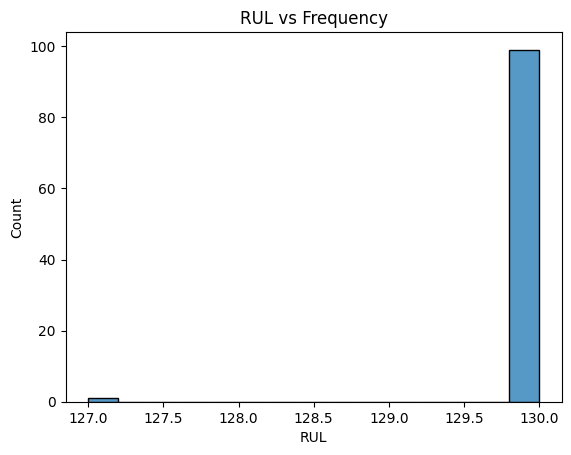

In [22]:
# Plotting of RUL
unit_rul_max = train_df[["engine_number", "RUL"]].groupby("engine_number").max().reset_index()
sns.histplot(unit_rul_max, x = "RUL", bins=15)
plt.title("RUL vs Frequency");

In [23]:
sensors_name = [sensor for sensor in train_df.columns.to_list() if sensor.startswith("sensor")]

In [24]:
sample_engine = train_df[train_df["engine_number"] == 1]

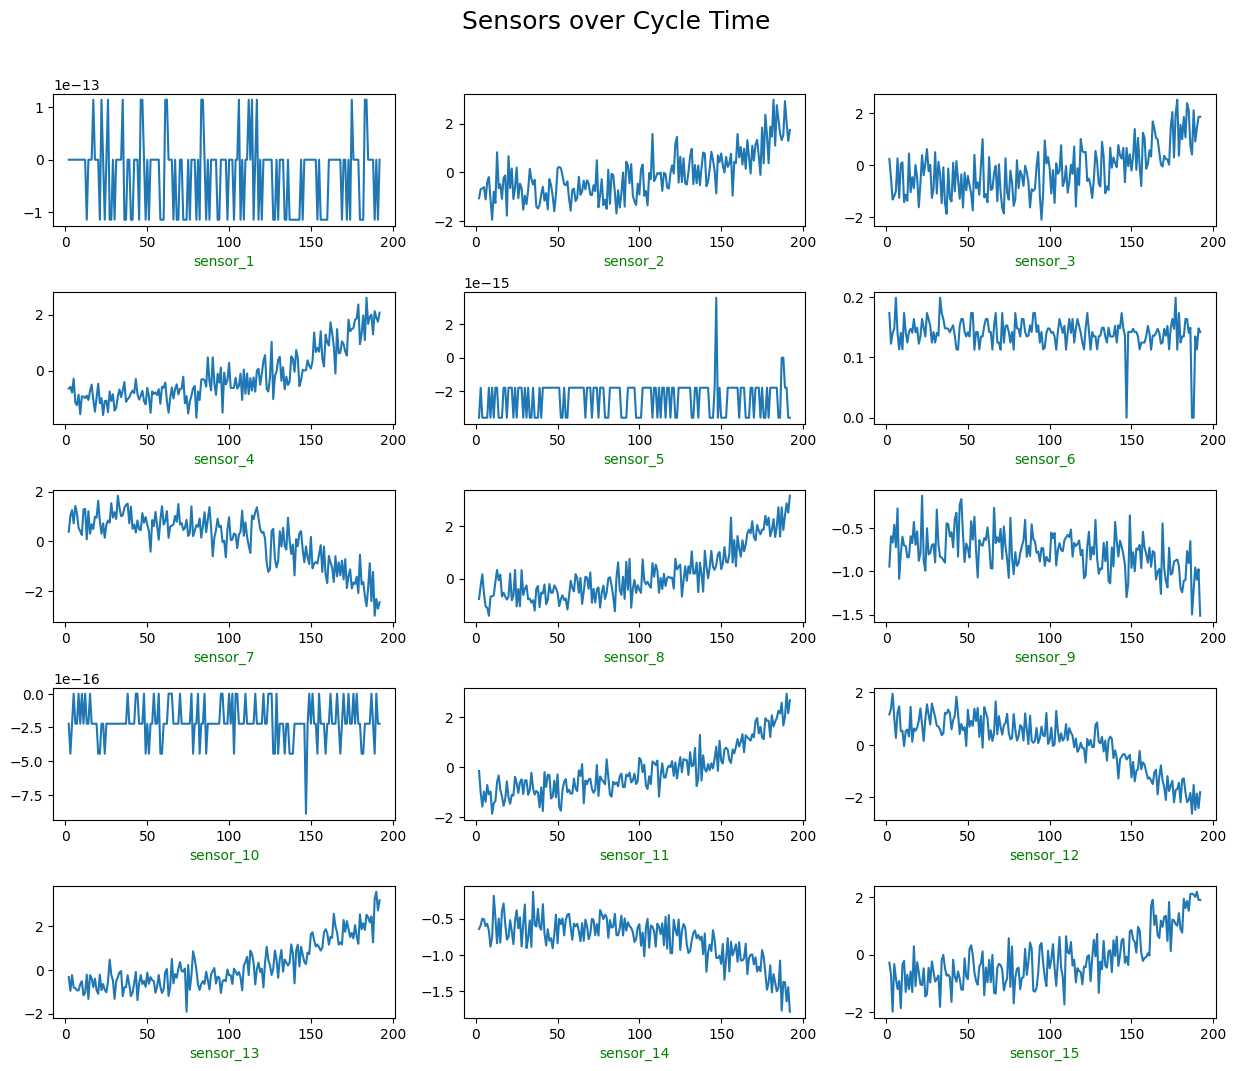

In [25]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sensors over Cycle Time", fontsize=18, y=0.95)
for sensor, ax in zip(sensors_name, axs.ravel()):
    ax.plot(sample_engine['time_in_cycles'], sample_engine[sensor])
    #ax.axvline(x = 200, color = "red")
    ax.set_xlabel(f"{sensor}", color = "green")


plt.show()
# We see a common change on point cycle 200

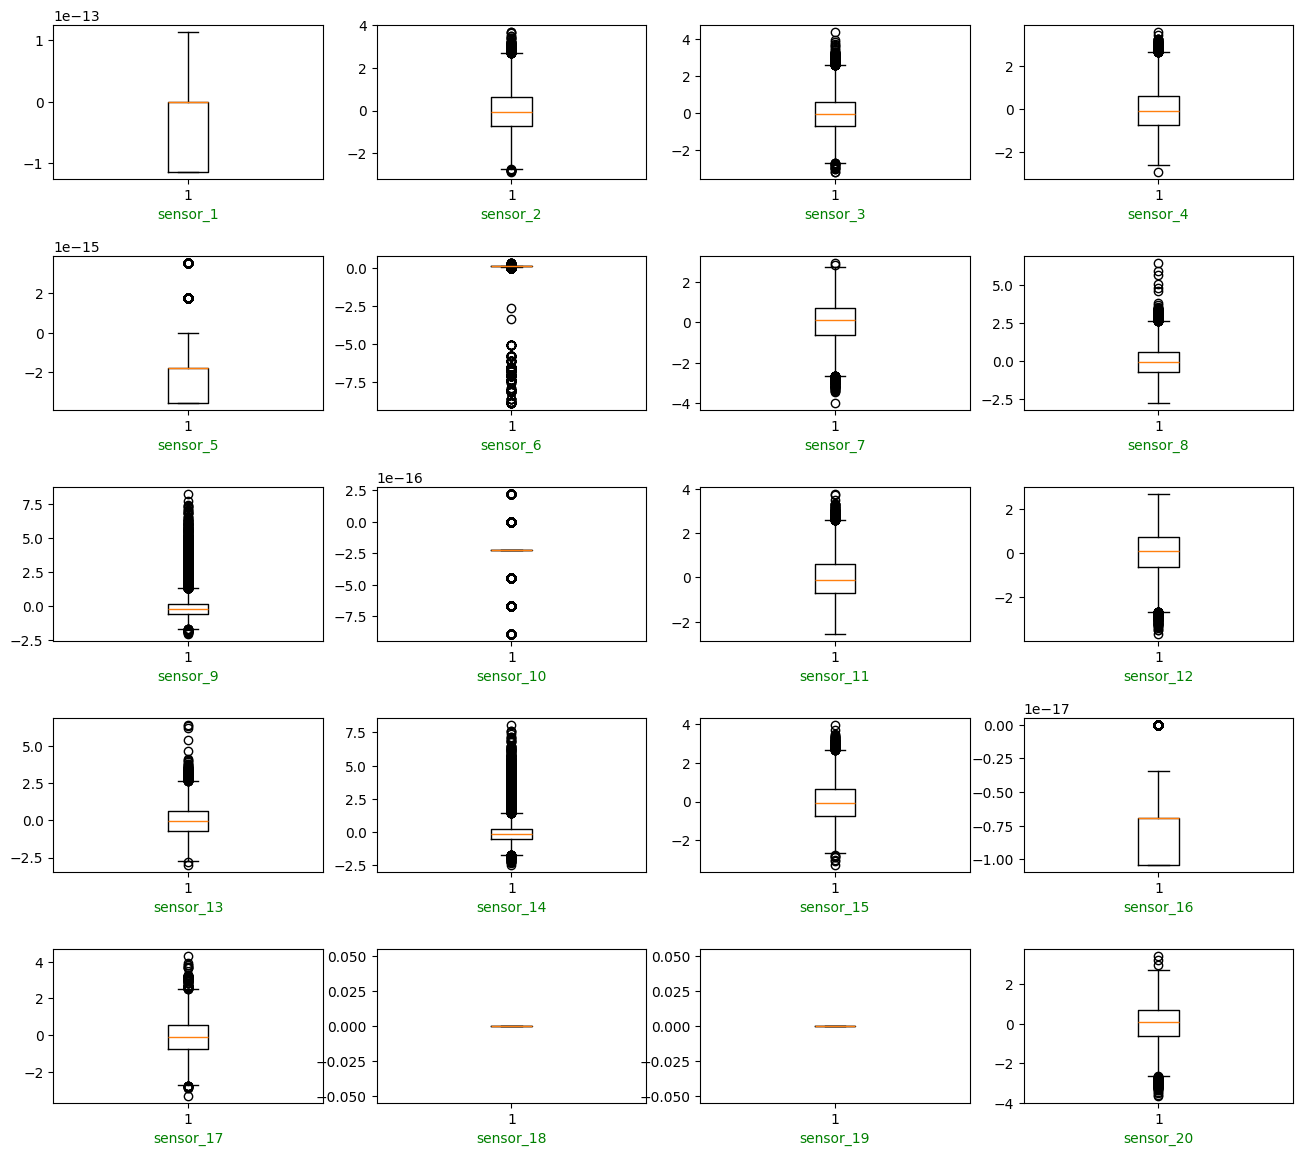

In [26]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Sensors over Cycle Time", fontsize=18, y=0.95)
for sensor, ax in zip(sensors_name, axs.ravel()):
    ax.boxplot(train_df[sensor])
    #ax.axvline(x = 200, color = "red")
    ax.set_xlabel(f"{sensor}", color = "green")


plt.show()

In [27]:
sensor_names=['sensor_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
sensor_names

['sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_20',
 'sensor_21']

In [28]:
pd.DataFrame(train_df,columns=['sensor_{}'.format(i) for i in range(1,22)])

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,0.000000e+00,-1.062471,0.234511,-0.646712,-3.552714e-15,0.173292,0.382474,-0.770002,-0.945659,-2.220446e-16,-0.153069,1.162816,-0.331016,-0.643337,-0.278535,-1.040834e-17,-0.736727,0,0.0,1.022336,1.225899
1,0.000000e+00,-0.695573,-0.499703,-0.583401,-1.776357e-15,0.122474,1.021193,-0.259242,-0.595790,-4.440892e-16,-1.025137,1.386703,-0.956327,-0.590848,-0.686442,-1.040834e-17,-1.989285,0,0.0,0.796552,0.503193
2,0.000000e+00,-0.657588,-1.323339,-0.790383,-3.552714e-15,0.140456,1.253917,0.166793,-0.669034,-2.220446e-16,-1.577675,1.951926,-0.240171,-0.499552,-1.975365,-1.040834e-17,-0.786985,0,0.0,0.377935,0.807742
3,0.000000e+00,-0.609319,-1.192763,-0.290340,-3.552714e-15,0.147166,0.715105,-0.562794,-0.463197,0.000000e+00,-0.976358,1.035654,-0.805378,-0.509131,-0.325795,-6.938894e-18,-0.166405,0,0.0,0.452048,1.081368
4,0.000000e+00,-1.110315,-0.996356,-1.148902,-3.552714e-15,0.198603,1.418536,-1.053811,-0.720656,-2.220446e-16,-1.386924,0.265787,-0.832286,-0.603779,-0.817052,-1.040834e-17,-1.447880,0,0.0,0.883637,0.660679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,-1.136868e-13,1.585834,1.144459,2.049980,-3.552714e-15,0.147979,-2.143543,1.264432,-0.024260,-2.220446e-16,1.869390,-2.520674,2.178502,-0.335208,1.339020,-1.040834e-17,2.341376,0,0.0,-1.743272,-2.805025
20626,0.000000e+00,1.712542,2.208052,2.711304,-3.552714e-15,0.147166,-2.858275,1.854703,-0.014061,0.000000e+00,1.867378,-2.353403,1.718693,-0.369135,1.957122,-6.938894e-18,1.116087,0,0.0,-2.845213,-1.194709
20627,1.136868e-13,1.453935,1.896238,2.117949,-1.776357e-15,0.163340,-2.682790,1.998977,0.097360,-2.220446e-16,2.043764,-1.868631,1.966092,-0.076253,3.211964,-1.040834e-17,3.101737,0,0.0,-2.073163,-3.274008
20628,-1.136868e-13,1.047597,2.341007,1.961756,-1.776357e-15,0.134491,-3.025244,2.115404,0.374571,-4.440892e-16,3.156576,-2.356638,1.857901,-0.245638,2.544344,-1.040834e-17,1.130069,0,0.0,-2.907446,-2.084814


array([[<Axes: title={'center': 'sensor_2'}>,
        <Axes: title={'center': 'sensor_3'}>,
        <Axes: title={'center': 'sensor_4'}>,
        <Axes: title={'center': 'sensor_7'}>],
       [<Axes: title={'center': 'sensor_8'}>,
        <Axes: title={'center': 'sensor_9'}>,
        <Axes: title={'center': 'sensor_11'}>,
        <Axes: title={'center': 'sensor_12'}>],
       [<Axes: title={'center': 'sensor_13'}>,
        <Axes: title={'center': 'sensor_14'}>,
        <Axes: title={'center': 'sensor_15'}>,
        <Axes: title={'center': 'sensor_17'}>],
       [<Axes: title={'center': 'sensor_20'}>,
        <Axes: title={'center': 'sensor_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

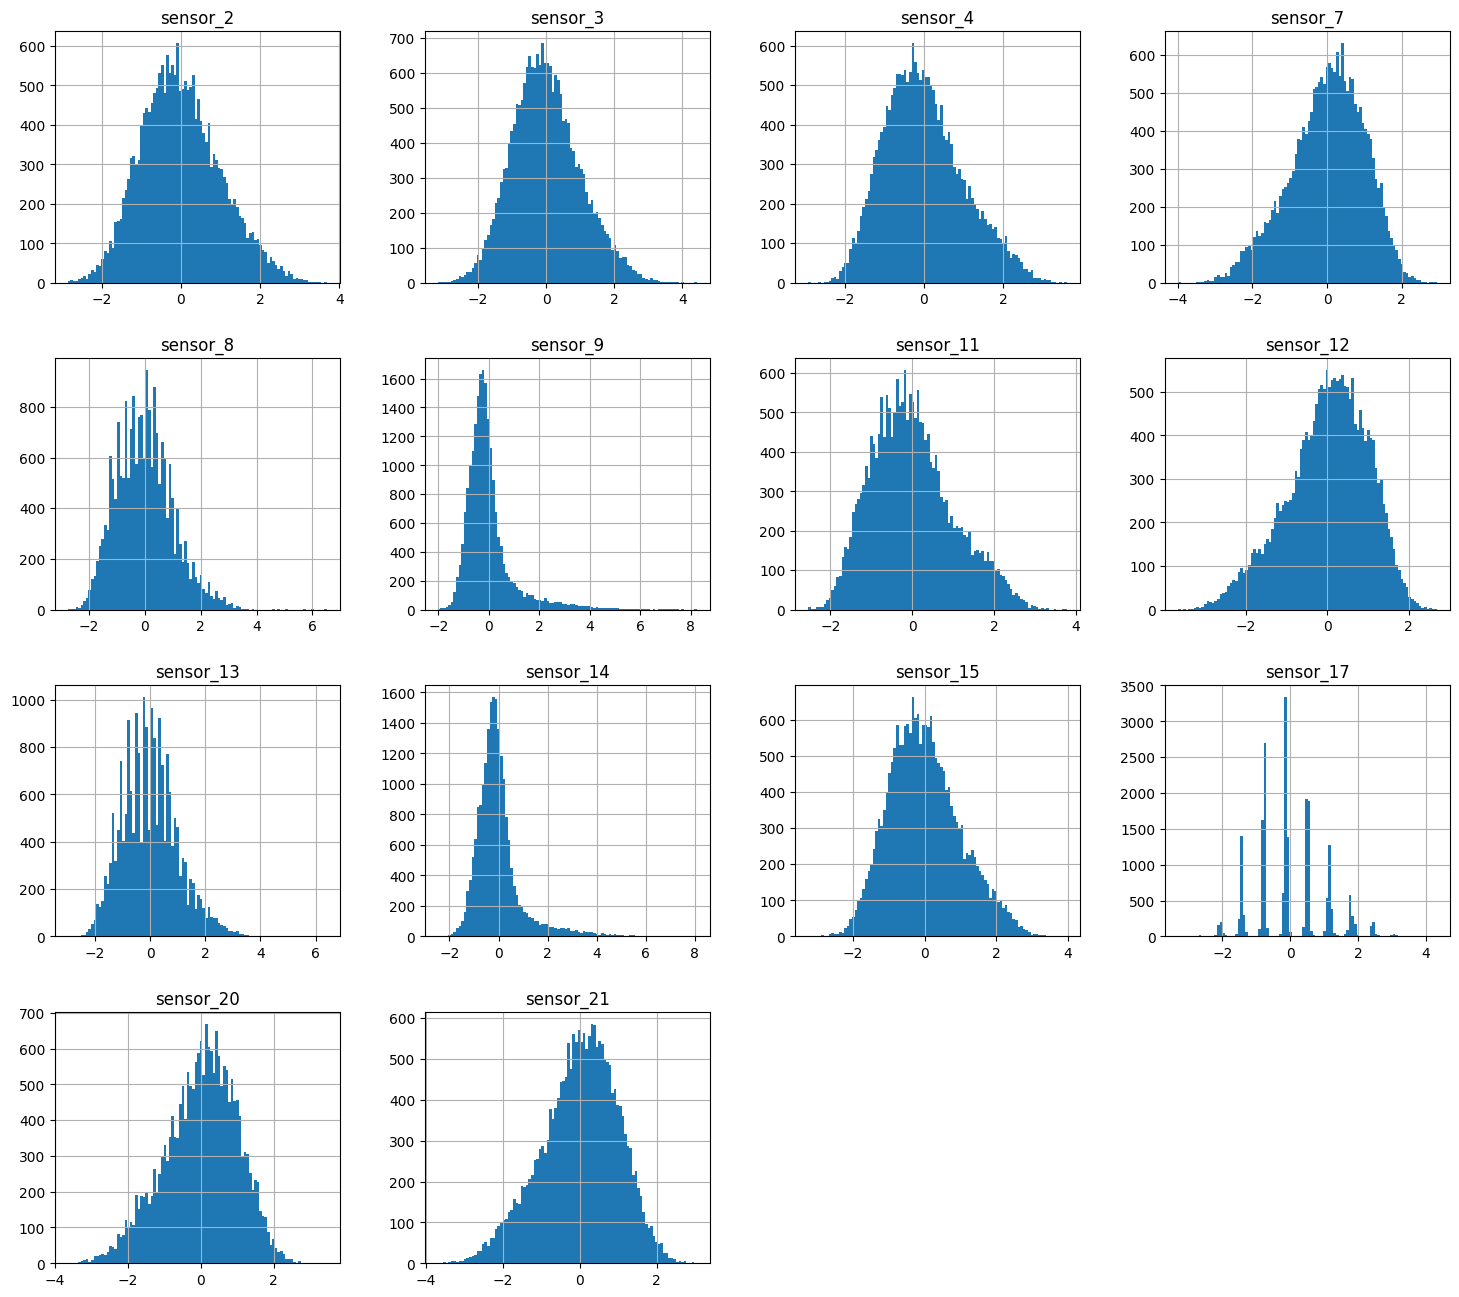

In [29]:
sensor_names=['sensor_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(train_df,columns=['sensor_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

In [30]:
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [31]:
sliding_window(train_df["time_in_cycles"], 30)

(array([[  2,   3,   4, ...,  29,  30,  31],
        [  3,   4,   5, ...,  30,  31,  32],
        [  4,   5,   6, ...,  31,  32,  33],
        ...,
        [168, 169, 170, ..., 195, 196, 197],
        [169, 170, 171, ..., 196, 197, 198],
        [170, 171, 172, ..., 197, 198, 199]]),
 array([ 32,  33,  34, ..., 198, 199, 200]))

In [32]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [33]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [34]:
data = train_df[feature_cols + ["RUL"]].values

In [35]:
data.shape

(20630, 25)

In [36]:
tf.data.Dataset.from_tensor_slices(data)

<_TensorSliceDataset element_spec=TensorSpec(shape=(25,), dtype=tf.float64, name=None)>

In [37]:
# TF Dataset Generator
def make_tf_sliding_window_dataset(data, window_size, batch_size):
    """
    data: NumPy array of shape (timesteps, num_features + 1)
    window_size: length of input sequence
    batch_size: batch size for training
    """

    total_features = data.shape[1] - 1 # Without RUL
    ds = tf.data.Dataset.from_tensor_slices(data)

    # Create sliding windows of size (window_size + 1)
    ds = ds.window(window_size + 1, shift= 1, drop_remainder= True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))

    # Split into (X,y)
    ds = ds.map(lambda window: (window[:-1, :total_features], # X: first window_size rows, all features
                                window[-1,-1]))  # y: last row's RUL
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [38]:
window_size = 30
batch_size = 4  # small for inspection

train_ds = make_tf_sliding_window_dataset(data, window_size, batch_size)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 24), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [39]:
for x_batch, y_batch in train_ds.take(1):
    print("Input batch shape:", x_batch.shape)  # Should be (batch_size, window_size, num_features)
    print("Label batch shape:", y_batch.shape)  # Should be (batch_size,)
    print("First X sample:\n", x_batch[0].numpy())
    print("First y sample:", y_batch[0].numpy())

Input batch shape: (4, 30, 24)
Label batch shape: (4,)
First X sample:
 [[-2.00817599e-01 -3.47687568e-01  0.00000000e+00  0.00000000e+00
  -1.06247077e+00  2.34511471e-01 -6.46712119e-01 -3.55271368e-15
   1.73291748e-01  3.82474323e-01 -7.70002471e-01 -9.45659449e-01
  -2.22044605e-16 -1.53069183e-01  1.16281604e+00 -3.31015998e-01
  -6.43337282e-01 -2.78535336e-01 -1.04083409e-17 -7.36726894e-01
   0.00000000e+00  0.00000000e+00  1.02233595e+00  1.22589875e+00]
 [-1.20556257e+00  3.50626815e-01  0.00000000e+00  0.00000000e+00
  -6.95573193e-01 -4.99702826e-01 -5.83401394e-01 -1.77635684e-15
   1.22474487e-01  1.02119270e+00 -2.59241560e-01 -5.95790165e-01
  -4.44089210e-16 -1.02513747e+00  1.38670321e+00 -9.56326945e-01
  -5.90848002e-01 -6.86442218e-01 -1.04083409e-17 -1.98928506e+00
   0.00000000e+00  0.00000000e+00  7.96551682e-01  5.03193264e-01]
 [-1.07957730e+00 -1.69670589e+00  0.00000000e+00  0.00000000e+00
  -6.57588102e-01 -1.32333923e+00 -7.90382681e-01 -3.55271368e-15
  

In [40]:
# Flattened Dataset Generator
def make_tf_sliding_dataset(data, window_size, batch_size):
  total_features = data.shape[1] -1 # -1 because last column is RUL

  ds = tf.data.Dataset.from_tensor_slices(data)
  ds = ds.window(window_size +1, shift = 1, drop_remainder= True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))

  # Flatten input window
  ds = ds.map(lambda window: (tf.reshape(window[:-1, : total_features], [-1]), #(window_size * num_features,)
                              window[-1,-1])) # scaler RUL
  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [41]:
train_ds = make_tf_sliding_dataset(data, window_size, batch_size)

In [42]:
# Model Architecture
from keras import layers, models

def build_baseline_model(input_shape):
  model = models.Sequential([layers.Input(shape = (input_shape,)),
                             layers.Dense(128, activation = "relu"),
                             layers.Dense(64, activation = "relu"),
                             layers.Dense(1)
                             ])
  return model

In [43]:
# Compile and Train
window_size = 30
num_features = 24
model = build_baseline_model(input_shape= window_size * num_features)

model.compile(
    optimizer= "adam",
    loss = "mae",
    metrics = ["mae", "mse"]
)
history = model.fit(train_ds, epochs=10)


Epoch 1/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 36.8082 - mae: 36.8082 - mse: 2594.9421
Epoch 2/10
  60/5150 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 17.7266 - mae: 17.7266 - mse: 483.7726

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5150/5150 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 26.6693 - mae: 26.6693 - mse: 1441.3568
Epoch 3/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 22.4092 - mae: 22.4092 - mse: 1019.2665
Epoch 4/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 20.0645 - mae: 20.0645 - mse: 834.1495
Epoch 5/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 18.1675 - mae: 18.1675 - mse: 698.5535
Epoch 6/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 17.3197 - mae: 17.3197 - mse: 621.2353
Epoch 7/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 16.6610 - mae: 16.6610 - mse: 564.2856
Epoch 8/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 16.5932 - mae: 16.5932 - mse: 556.4790
Epoch 9/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 16.1871 - mae: 16.1871 - mse: 538.9767
Epoch 10/10
5150/5150 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 15.9836 - mae: 15.9836 - mse: 520.4323


In [44]:
mea = model.evaluate(train_ds)

5150/5150 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 20.4592 - mae: 20.4592 - mse: 761.4120


In [45]:
print(f"MAE on training data: {mea} cycles")


MAE on training data: [20.684709548950195, 20.684709548950195, 777.2755126953125] cycles


In [51]:
"""import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for x_batch, y_batch in train_ds:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
"""

'import numpy as np\nimport matplotlib.pyplot as plt\n\ny_true = []\ny_pred = []\n\nfor x_batch, y_batch in train_ds:\n    preds = model.predict(x_batch)\n    y_true.extend(y_batch.numpy())\n    y_pred.extend(preds.flatten())\n\ny_true = np.array(y_true)\ny_pred = np.array(y_pred)\n'

In [47]:
y_pred = model.predict(train_ds)

5150/5150 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


def score_func(y_true,y_pred):
    lst = [
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]

    print(f' mean absolute error {lst[0]}')
    print(f' root mean squared error {lst[1]}')
    print(f' R2 score {lst[2]}')

In [59]:
y_true = []

for _, y_batch in train_ds:
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)

In [62]:
score_func(y_true, y_pred)

 mean absolute error 20.68
 root mean squared error 27.879741749162598
 R2 score 0.59
